# TensorFlow Intro

In [74]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [75]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [76]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


Randomize the data and scale `median_house_value` field

In [77]:
chd = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
chd['median_house_value'] /= 1000.0
chd.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2402,-117.5,33.5,15.0,426.0,62.0,133.0,45.0,5.1,447.4
16627,-122.7,38.4,30.0,2099.0,406.0,1156.0,401.0,2.8,152.3
3497,-117.9,33.9,33.0,4181.0,804.0,2049.0,834.0,4.3,201.6
957,-117.1,32.8,31.0,1235.0,387.0,816.0,397.0,1.6,122.5
7262,-118.3,34.1,28.0,2223.0,752.0,1271.0,684.0,2.5,232.1


In [79]:
# 1) Define features.

rooms_feature = chd[['total_rooms']]  # pandas.core.frame.DataFrame
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

# 2) Define target.

targets = chd['median_house_value']

In [80]:
# 3) Configure LinearRegressor

# We'll train this model using the GradientDescentOptimizer, 
# which implements Mini-Batch Stochastic Gradient Descent (SGD).
gdo = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# Gradient clipping helps ensure numerical stability and prevents exploding gradients.
clip_gdo = tf.contrib.estimator.clip_gradients_by_norm(gdo, 5.0)

linear_regerssor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=clip_gdo
)

In [81]:
# 4) Define the Input Function

def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels    

In [82]:
# 5) Train the Model

_ = linear_regerssor.train(
    input_fn=lambda:input_fn(rooms_feature, targets),
    steps=100
)

In [83]:
# 6) Evaluate the Model

prediction_input_fn = lambda:input_fn(rooms_feature, targets, shuffle=False, num_epochs=1)
predictions = linear_regerssor.predict(input_fn=prediction_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mse = metrics.mean_squared_error(predictions, targets)
root_mse = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mse)
print("Root Mean Squared Error (on training data): %0.3f" % root_mse)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 236.685


In [84]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Visualize the data and the line we've learned:

In [86]:
sample = chd.sample(n=300)

Weight: 0.000
Bias: 0.000


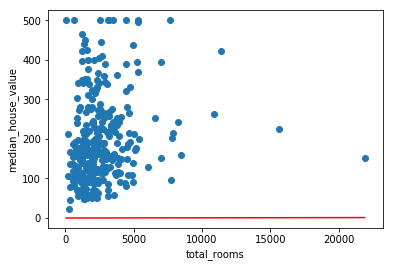

In [101]:
x0 = sample['total_rooms'].min()
x1 = sample['total_rooms'].max()

weight = linear_regerssor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regerssor.get_variable_value('linear/linear_model/bias_weights')

print("Weight: %0.2f" % weight)
print("Bias: %0.2f" % bias)

y0 = weight*x0 + bias
y1 = weight*x1 + bias

# Plot regression line
plt.plot([x0,x1], [y0,y1], c='red')

# Plot data sample
plt.scatter(sample['total_rooms'], sample['median_house_value'])

plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

plt.show()

## Tweak the Model Hyperparams

In [125]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
            to use as input feature.
    """
    
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = chd[[my_feature]]
    my_label = "median_house_value"
    targets = chd[my_label]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = chd.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    template = "{0:6}|{1:10}|{2:6}|{3:6}"
    print(template.format("period", "RMSE", "weight", "bias"))
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
     
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        # Occasionally print the current loss, weight and bias.
        print(template.format(
            "%02d"  % period,
            "%0.2f" % root_mean_squared_error,
            "%0.2f" % weight,
            "%0.2f" % bias
        ))
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, 
                                          sample[my_feature].max()), 
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
        
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
period|RMSE  |weight|bias  
00    |225.63|0.00  |0.00  
01    |214.42|0.01  |0.00  
02    |204.04|0.01  |0.00  
03    |194.97|0.02  |0.00  
04    |186.60|0.02  |0.00  
05    |180.27|0.03  |0.00  
06    |174.38|0.03  |0.00  
07    |170.45|0.04  |0.00  
08    |168.50|0.04  |0.00  
09    |166.96|0.05  |0.00  
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,119.5,207.3
std,98.5,116.0
min,0.1,15.0
25%,66.1,119.4
50%,96.1,180.4
75%,142.4,265.0
max,1714.8,500.0


Final RMSE (on training data): 166.96


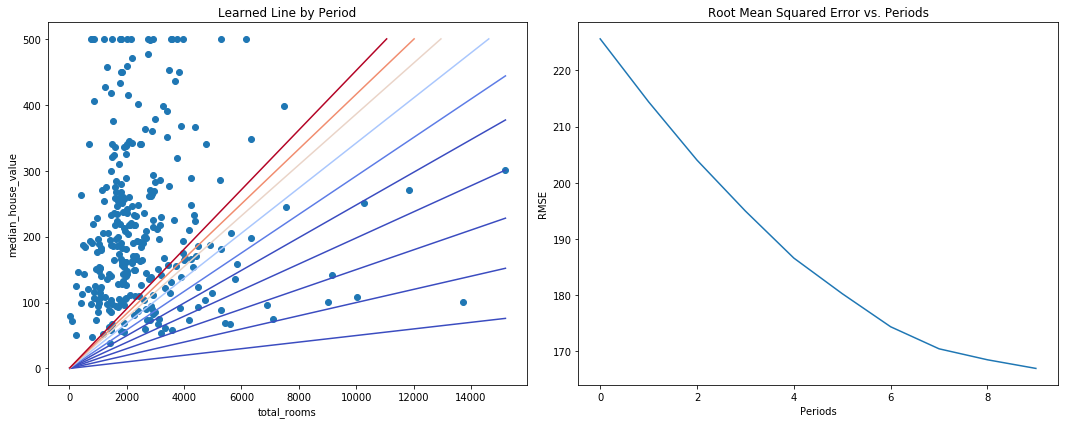

In [129]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)